# UMAP  on whole genome sequenced data

Here individuals are from 1001 genomes, Irish (sequenced in this work), African, Chinese, N.Am. Herbarium and N.Am collected during this work

In [5]:

###By:Gautam Shirsekar

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import watermark
from mpl_toolkits.mplot3d import Axes3D


#for VCF 
import allel
import zarr
import h5py

#for Dimension Reduction
import umap
import umap.plot
from sklearn.decomposition import PCA as PCA


## Import colour palettes for later on
from bokeh.palettes import Category20
from bokeh.palettes import Category20b

from bokeh.palettes import Purples
from bokeh.palettes import Greens
from bokeh.palettes import YlOrBr
from bokeh.palettes import YlOrRd
from bokeh.palettes import PuOr
from bokeh.palettes import RdGy
from bokeh.palettes import Turbo256
       

### Versions of the Software/Hardware and Libraries used

In [6]:
%reload_ext watermark
%watermark
%watermark --iversions

Last updated: 2021-01-01T10:01:25.367998+01:00

Python implementation: CPython
Python version       : 3.7.3
IPython version      : 7.17.0

Compiler    : GCC 7.3.0
OS          : Linux
Release     : 5.4.0-58-generic
Machine     : x86_64
Processor   : x86_64
CPU cores   : 16
Architecture: 64bit

zarr      : 2.4.0
seaborn   : 0.10.1
matplotlib: 2.2.4
umap      : 0.4.6
allel     : 1.2.1
watermark : 2.1.0
pandas    : 1.1.0
numpy     : 1.19.1
sklearn   : 0.23.2
h5py      : 2.10.0



### Functions Used in the Notebook 

In [3]:
####FUNCTIONS USED###
def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+.02, point['y'], str(point['val']), )
        
def ld_prune(gn, size, step, threshold=.1, n_iter=1):
    for i in range(n_iter):
        loc_unlinked = allel.locate_unlinked(gn, size=size, step=step, threshold=threshold)
        n = np.count_nonzero(loc_unlinked)
        n_remove = gn.shape[0] - n
        print('iteration', i+1, 'retaining', n, 'removing', n_remove, 'variants')
        gn = gn.compress(loc_unlinked, axis=0)
    return gn #ref:http://alimanfoo.github.io/2015/09/28/fast-pca.html

## Metadata processing and Color assignments

In [13]:
indPop = pd.read_csv("/mnt/bigdisk/work/northAmericanArabidopsis/evolHistory/RADseqData/WGS.popRegions", sep="\t", names=['ind','subcluster', 'region'])
#For population based plotting
#populations = indPop["pop"].unique()

#for state based plotting
states = indPop['region'].unique()
n_states = len(states)


#from bokeh import diverging_palette
import bokeh
diverging_palette = bokeh.palettes.diverging_palette(Category20[20], Category20b[20],n_states, 0.5)


color_dict={}
#for colors over 20
for i, pop in enumerate(states):
    color_dict[pop] = diverging_palette[i]

#for colors upto20
#for i, pop in enumerate(states):
#    color_dict[pop] = Category20[20][i]

## VCF processing

In [8]:
#Read vcf file and store in hdf5 format
allel.vcf_to_hdf5('merged.bi.lmiss90.ed.allChr.bgl.WGSinds.vcf.gz',
                            'merged.bi.lmiss90.ed.allChr.bgl.WGSinds.vcf.gz.h5', fields='*', overwrite=True)

In [4]:
#prepare callset
callset = h5py.File('merged.bi.lmiss90.ed.allChr.bgl.WGSinds.vcf.gz.h5', mode='r')

In [5]:
#extract chromosomes, positions and genotype information and then convert in 012 format
chrom = callset['variants/CHROM']
pos = callset['variants/POS']

gt = allel.GenotypeArray(callset['calldata/GT'])
gt[gt == -1] = 0
gt_012 = gt.to_n_alt(fill=0) #converting to 012 

In [6]:
#LD-based pruning 
gt_012_p = ld_prune(gt_012, size=500, step=50, threshold=.5, n_iter=5)


iteration 1 retaining 225548 removing 637386 variants
iteration 2 retaining 199774 removing 25774 variants
iteration 3 retaining 197867 removing 1907 variants
iteration 4 retaining 197531 removing 336 variants
iteration 5 retaining 197391 removing 140 variants


In [9]:
transposed_genotype_matrix = np.array(gt_012_p).transpose()

In [10]:
transposed_genotype_matrix.shape

(1537, 197391)

## UMAP without PCA

In [11]:
## UMAP with Euclidean metric ##
mapper_gt_umap_lownn = umap.UMAP(n_neighbors=15, min_dist=0.5, random_state=7767, metric="euclidean").fit(transposed_genotype_matrix)

In [14]:
embeddingDf = pd.DataFrame(mapper_gt_umap_lownn.embedding_, )
#sns.scatterplot(embeddingDf[0], embeddingDf[1]);


#add ind/pop columns
embeddingDf["ind"]=indPop["ind"]
embeddingDf["subcluster"]=indPop["subcluster"]
embeddingDf['region']=indPop['region']

#rename embeddings with emb1 and emb2
embeddingDf.rename(columns={0:"emb1", 1:"emb2"}, inplace=True)

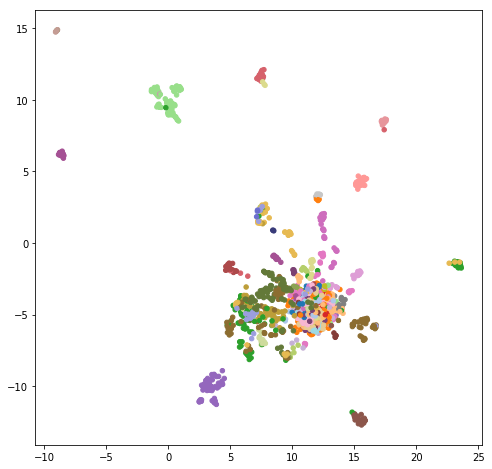

In [15]:
#plot scatter1
fig, ax=plt.subplots(figsize=(8,8))
plt.scatter(embeddingDf.emb1,embeddingDf.emb2,s=20, c=embeddingDf['region'].apply(lambda x: color_dict[x]) )

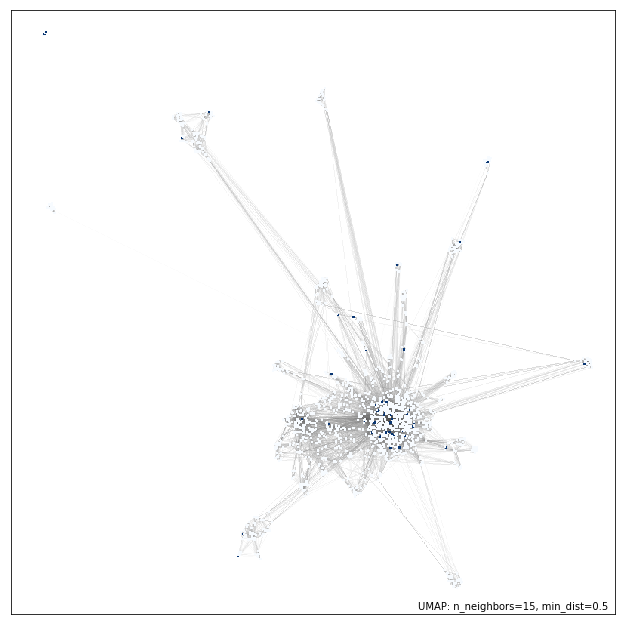

In [16]:
#plot connections
import warnings; warnings.simplefilter('ignore')
umap.plot.connectivity(mapper_gt_umap_lownn, show_points=True)

# PCA based UMAP

In [17]:
# Project onto the PC axes
pca_full = PCA(n_components=100).fit(transposed_genotype_matrix)
proj_pca = pca_full.fit_transform(transposed_genotype_matrix)

### With nn=100 and min_dist=0.8

In [ ]:
mapper_pca_umap = umap.UMAP(n_neighbors=100, min_dist=0.8, metric="euclidean", random_state=10991,n_components=2).fit(proj_pca[:,:50])

### With nn=15 and min_dist=0.5

In [43]:

#mapper_pca_umap = umap.UMAP(n_neighbors=15, min_dist=0.5, metric="euclidean", random_state=10991,n_components=2).fit(proj_pca[:,:50])

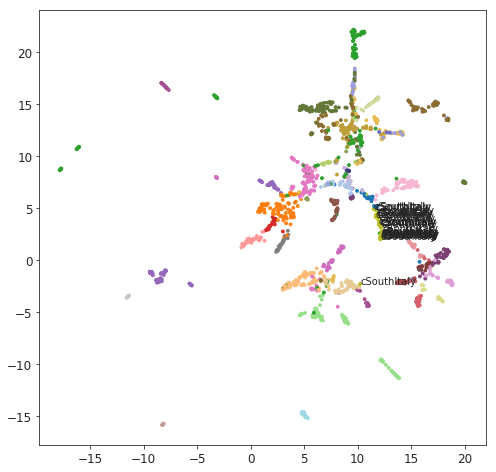

In [82]:
embeddingDf = pd.DataFrame(mapper_pca_umap.embedding_, )

#add ind/pop columns
embeddingDf["ind"]=indPop["ind"]
embeddingDf["subcluster"]=indPop["subcluster"]
embeddingDf['region']=indPop['region']

#rename embeddings with emb1 and emb2
embeddingDf.rename(columns={0:"emb1", 1:"emb2"}, inplace=True)
#plot scatter1
fig, ax=plt.subplots(figsize=(8,8))
plt.scatter(embeddingDf.emb1,embeddingDf.emb2,s=8, c=embeddingDf['region'].apply(lambda x: color_dict[x]) )

labIN=embeddingDf[embeddingDf['region']=="cSouthItaly"]
label_point(labIN["emb1"], labIN["emb2"], labIN["region"], plt.gca())

Text(0,0.5,'UMAP2')

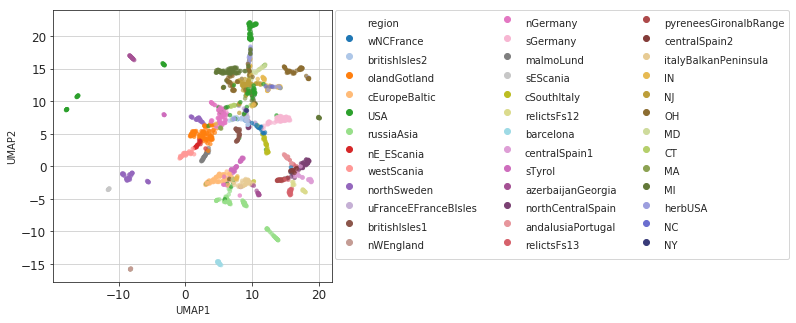

In [80]:
plt.rcParams['xtick.labelsize']=12
plt.rcParams['ytick.labelsize']=12
sns.set_style("ticks")
fig, ax=plt.subplots(figsize=(5,5))
plt.grid()
sns.scatterplot(embeddingDf["emb1"], embeddingDf["emb2"], hue=embeddingDf["region"],ax=ax, palette=color_dict,s=20,
                linewidth=0,alpha=0.7 )
plt.legend(bbox_to_anchor=(1.01, 1),borderaxespad=0,ncol=3,handleheight=2.4, labelspacing=0.05)
plt.xlabel("UMAP1")
plt.ylabel("UMAP2")

#plt.savefig("umapWGS_raw.png", dpi=300, bbox_inches='tight')
#labIN=embeddingDf[embeddingDf['region']=="sTyrol"]
#label_point(labIN["emb1"], labIN["emb2"], labIN["region"], plt.gca())


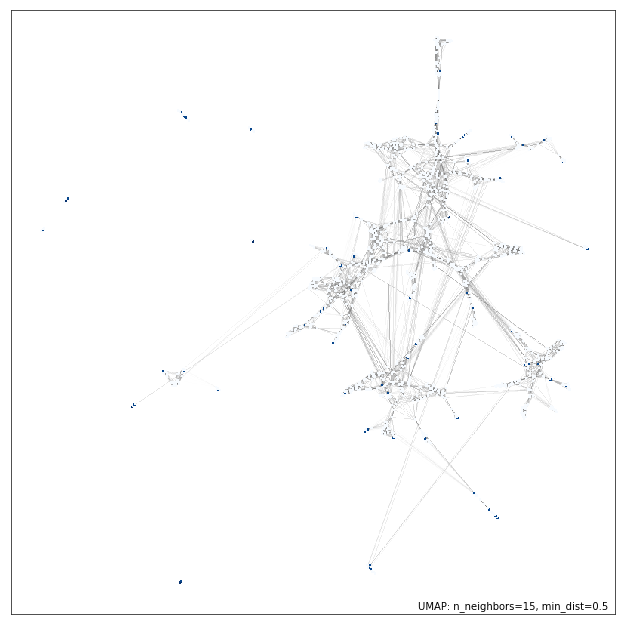

In [78]:
#plot connections
import warnings; warnings.simplefilter('ignore')
#fig, ax=plt.subplots(figsize=(5,5))
umap.plot.connectivity(mapper_pca_umap, show_points=True,)
#plt.savefig("umapWGS_connectivity.png", dpi=300)
plt.show()

#### Write output to txt

In [79]:
#Output written to txt file (later processed with ggplot in R for plotting)
embeddingDf.to_csv("umapOut_nn100_minDist0_8_euclidean.txt", sep="\t", float_format="%.4f", index=False)
#embeddingDf.to_csv("umapOut_nn15_minDist0_5_euclidean.txt", sep="\t", float_format="%.4f", index=False)

In [185]:
'''
###3Components

mapper_pca_umap = umap.UMAP(n_neighbors=15, min_dist=0.5, metric="euclidean", random_state=10991,n_components=3).fit(proj_pca[:,:50])
embeddingDf = pd.DataFrame(mapper_pca_umap.embedding_, )

#add ind/pop columns
embeddingDf["ind"]=indPop["ind"]
embeddingDf["subcluster"]=indPop["subcluster"]
embeddingDf['region']=indPop['region']

#rename embeddings with emb1 and emb2
embeddingDf.rename(columns={0:"emb1", 1:"emb2",2:"emb3"}, inplace=True)
#plot scatter1
fig, ax=plt.subplots(figsize=(8,8))
plt.scatter(embeddingDf.emb1,embeddingDf.emb2,s=8, c=embeddingDf['region'].apply(lambda x: color_dict[x]) )
fig= plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(embeddingDf.emb1,embeddingDf.emb2,embeddingDf.emb3,s=8, c=embeddingDf['region'].apply(lambda x: color_dict[x]))
'''